# Construction of the data

We focus on the repartition of types by author and their absolute participations.

In [10]:
import config
from analytics import operation_builder
from analytics.parser import *
from analytics.visualization import *
import pandas as pd
import os

list_of_elem_ops_per_pad = dict()
elemOpsCounter = 0
root_of_dbs = "belgian_experiment/"
for (dirpath, dirnames, filenames) in os.walk(root_of_dbs):
    for filename in filenames:
        if ".db" in filename:
            path_to_db = os.path.join(dirpath, filename)
            list_of_elem_ops_per_main, _ = get_elem_ops_per_pad_from_db(path_to_db=path_to_db, editor='etherpadSQLite3')
            pad_name = path_to_db[len(root_of_dbs):path_to_db.find("data") - 1]
            assert len(list_of_elem_ops_per_main.keys()) == 1
            list_of_elem_ops_per_pad[pad_name] = list_of_elem_ops_per_main['main']

pads, _, elem_ops_treated = operation_builder.build_operations_from_elem_ops(list_of_elem_ops_per_pad,
                                                                             config.maximum_time_between_elem_ops)

for pad_name in pads:
    elemOpsCounter += len(elem_ops_treated[pad_name])
    pad = pads[pad_name]
    # create the paragraphs
    pad.create_paragraphs_from_ops(elem_ops_treated[pad_name])
    # classify the operations of the pad
    pad.classify_operations(length_edit=config.length_edit, length_delete=config.length_delete)
    # find the context of the operation of the pad
    pad.build_operation_context(config.delay_sync, config.time_to_reset_day, config.time_to_reset_break)

print("Loaded %s pads with a total of %s elementary operations" % (str(len(pads)), str(elemOpsCounter)))

Loaded 17 pads with a total of 57147 elementary operations


In [17]:
def compute_overall_op_type(pad, jump=False):
    """
    Compute the type counts of all operations of the pad.

    :param pad:
    :return: DataFrame with the counts
    """
    # Create DataFrame and fill it
    df = pd.DataFrame(columns=('Pad name', 'Types', 'Authors'))
    for i, op in enumerate(pad.operations):
        df.loc[i] = [pad.pad_name, op.type, op.author]
    if not jump:
        df = df[df['Types'] != 'jump']
    return df

In [19]:
counts = []
for pad in pads:
    counts.append(compute_overall_op_type(pads[pad]))
df_counts = pd.concat(counts)
df_counts.head()

,Pad name,Types,Authors
0,Group 7_session 1,paste,Etherpad_admin
3,Group 7_session 1,paste,Etherpad_admin
6,Group 7_session 1,paste,Etherpad_admin
9,Group 7_session 1,paste,Etherpad_admin
12,Group 7_session 1,edit,a.hKB2cgaxHJpIurYR


In [80]:
df_types = df_counts.groupby(by=['Pad name', 'Authors', 'Types'])['Types'].count().unstack().fillna(value=0)
df_types = df_types.drop(labels=['Etherpad_admin'], level='Authors')
df_types['total'] = df_types.sum(axis=1)
df_types = df_types.merge(df_types.sum(axis=0, level='Pad name'), left_index=True, right_index=True)
df_prop_types = pd.DataFrame()
df_prop_types['delete'] = df_types['delete_x'].div(df_types['delete_y'])
df_prop_types['edit'] = df_types['edit_x'].div(df_types['edit_y'])
df_prop_types['paste'] = df_types['paste_x'].div(df_types['paste_y'])
df_prop_types['write'] = df_types['write_x'].div(df_types['write_y'])
df_prop_types['total'] = df_types['total_x'].div(df_types['total_y'])
df_prop_types.head()

delete      edit     paste     write  \
Pad name           Authors                                                      
Group 10_session 1 a.5jgzYp1oOxBDGwcJ  0.085714  0.193252  0.793651  0.107438   
                   a.hDqEuezMoA7CVUDG  0.085714  0.113497  0.031746  0.181818   
                   a.nEzl5qtUhUYiw9nz  0.457143  0.220859  0.111111  0.314050   
                   a.w8mseKIkEjIt0fVP  0.371429  0.472393  0.063492  0.396694   
Group 11_session 1 a.1PFVWhCNTiGYVIaY  0.200000  0.235849  0.094340  0.311688   

                                          total  
Pad name           Authors                       
Group 10_session 1 a.5jgzYp1oOxBDGwcJ  0.236697  
                   a.hDqEuezMoA7CVUDG  0.117431  
                   a.nEzl5qtUhUYiw9nz  0.244037  
                   a.w8mseKIkEjIt0fVP  0.401835  
Group 11_session 1 a.1PFVWhCNTiGYVIaY  0.228883

In [24]:
props = []
for pad in pads:
    # Compute author proportions
    authors, proportions = pads[pad].author_proportions(considerate_admin=True)

    # Transform the array in dataframe
    df = pd.DataFrame({'Participation proportion': proportions,
                        'Authors': authors,
                        'Pad name': pad                       
                        })
    props.append(df)
df_props = pd.concat(props)

In [95]:
df_authors = df_prop_types.merge(df_props.set_index(['Pad name', 'Authors']), left_index=True, right_index=True)
df_authors

delete      edit     paste     write  \
Pad name           Authors                                                      
Group 10_session 1 a.5jgzYp1oOxBDGwcJ  0.085714  0.193252  0.793651  0.107438   
                   a.hDqEuezMoA7CVUDG  0.085714  0.113497  0.031746  0.181818   
                   a.nEzl5qtUhUYiw9nz  0.457143  0.220859  0.111111  0.314050   
                   a.w8mseKIkEjIt0fVP  0.371429  0.472393  0.063492  0.396694   
Group 11_session 1 a.1PFVWhCNTiGYVIaY  0.200000  0.235849  0.094340  0.311688   
                   a.74ZU5hQroa6WJS79  0.280000  0.278302  0.056604  0.220779   
                   a.HZOxYvWbZLM4ieXG  0.120000  0.179245  0.094340  0.285714   
                   a.MNFXx8d42JQYfsjV  0.000000  0.000000  0.000000  0.012987   
                   a.YfOMe3dqDz6WZRlp  0.400000  0.306604  0.754717  0.168831   
Group 12_session 1 a.Ow4ONNP37D54a40o  0.169811  0.305369  0.050000  0.248366   
                   a.UeuTNbVnGSsaCzbV  0.056604  0.114094  0.100000  0.143791   
                   a.f0qjPO8n53bi2G8i  0.415094  0.395973  0.375000  0.202614   
                   a.wHHPOgyYIZdYkPFC  0.358491  0.184564  0.475000  0.405229   
Group 13_session 1 a.3FH5ZvD7dsBUAehf  0.191781  0.308943  0.540000  0.171429   
                   a.fNwYWJIYf01Uarp3  0.260274  0.337398  0.200000  0.276190   
                   a.kvxnPMp07l04RFWb  0.506849  0.211382  0.160000  0.352381   
                   a.ytwDMn88v4YgE1vr  0.041096  0.142276  0.100000  0.200000   
Group 14_session 1 a.R9DBC8vPX8hzUyfe  0.081081  0.106061  0.190476  0.177419   
                   a.WYx5zmCtG5kVIFNZ  0.270270  0.190909  0.095238  0.266129   
                   a.aLS0R3gIuY5b620W  0.459459  0.518182  0.571429  0.346774   
                   a.cYrLWKWuo1JQuhpv  0.189189  0.184848  0.142857  0.209677   
Group 15_session 1 a.4g8ohfrjt8DEsOvw  0.142857  0.185792  0.070423  0.235955   
                   a.Th9SE60eEmhV39Qc  0.142857  0.174863  0.042254  0.292135   
                   a.hT4ddF8gwN0DtlWK  0.428571  0.398907  0.422535  0.191011   
                   a.uQiY8YmdihOXOKpz  0.285714  0.240437  0.464789  0.280899   
Group 16_session 1 a.3CVUHqiOtP4Yo4zs  0.150000  0.211538  0.263158  0.244444   
                   a.PUQnkqGkjK4rMIyu  0.200000  0.519231  0.368421  0.355556   
                   a.z71UvMGpYT0oo8fs  0.650000  0.269231  0.368421  0.400000   
Group 17_session 1 a.1p4VKfqdxJ4Eu7Hd  0.157895  0.183673  0.454545  0.255814   
                   a.1tI6h036anGC4S4C  0.210526  0.107143  0.181818  0.267442   
...                                         ...       ...       ...       ...   
Group 2_session 1  a.lPrFmYmTZ4ZfBauV  0.214286  0.152174  0.178571  0.269231   
Group 3_session 1  a.6LfWOG0NogOBJ3NL  0.414634  0.278261  0.227273  0.314516   
                   a.GH0LFzFTj5ZQbauP  0.195122  0.313043  0.318182  0.209677   
                   a.fMiMhkVFrRmoecSB  0.317073  0.260870  0.227273  0.274194   
                   a.zuZ6m0VcJeyPAXMe  0.073171  0.147826  0.227273  0.201613   
Group 4_session1-  a.A2J0ySM0MfX264JH  0.172414  0.232227  0.171429  0.198113   
                   a.PTWBNv0ZzNIhweYM  0.241379  0.284360  0.057143  0.273585   
                   a.agpfIT8dahLNPBiY  0.137931  0.180095  0.114286  0.216981   
                   a.riG7V16BuBkPlVQR  0.448276  0.303318  0.657143  0.311321   
Group 5_session 1  a.6JRWK9EZZvC8MC0F  0.166667  0.224242  0.416667  0.198198   
                   a.789Ytmld0jANoH6t  0.333333  0.133333  0.416667  0.144144   
                   a.e7jetRZSfHztu6rr  0.166667  0.309091  0.000000  0.252252   
                   a.yifPL5iGmfeI8r8N  0.333333  0.333333  0.166667  0.405405   
Group 6_session 1  a.2Z5TPMrQvOKdh1tW  0.297297  0.068063  0.500000  0.104762   
                   a.57pSX1fZkplQZMQF  0.405405  0.492147  0.125000  0.228571   
                   a.6IdZwUTEcVNm8g6J  0.216216  0.319372  0.187500  0.247619   
                   a.WExRlhrKGEwZHi5P  0.081081  0.094241  0.156250  0.2

## Clusterization and PCA

In [83]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Louis\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Difference in cluster centers features
[('delete', 0.2149657781660979),
 ('edit', 0.18648211246311497),
 ('paste', 0.16203906453217315),
 ('write', 0.09736341712828991),
 ('total', 0.17487131857602525),
 ('Participation proportion', 0.16718521089877753)]

Difference between the mean features of each cluster
delete                      0.214966
edit                        0.186482
paste                       0.162039
write                       0.097363
total                       0.174871
Participation proportion    0.167185
Name: mean, dtype: float64


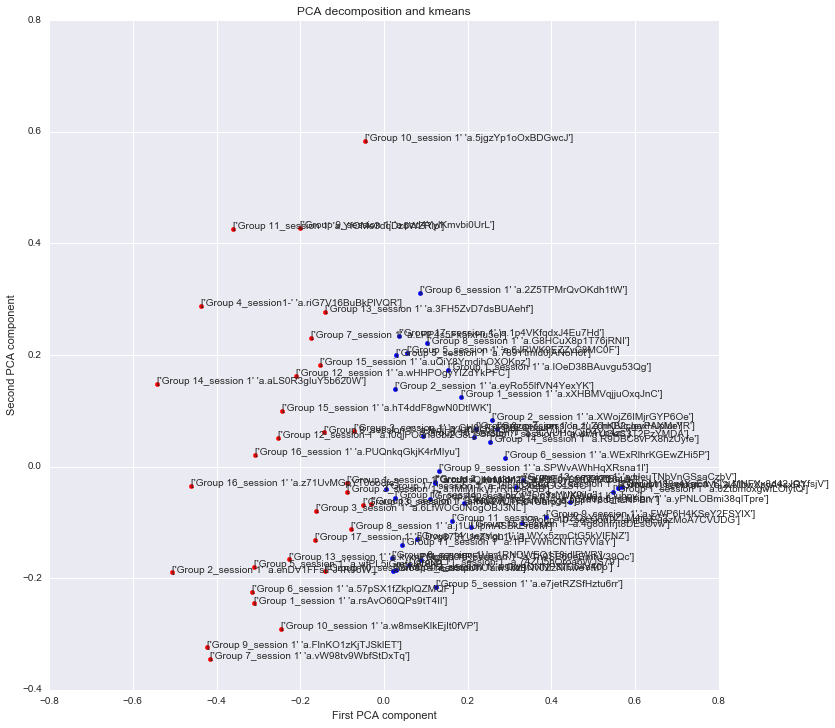

In [94]:
name_authors = list(df_authors.index)

kmeans = KMeans(n_clusters=2)
assignments = kmeans.fit_predict(df_authors)

pca = PCA(n_components=2,random_state=1)
pca.fit(df_authors)

df_0 = df_authors[assignments == 0]
X_0 = pca.transform(df_0)
pad_names_0 = np.array(name_authors)[assignments == 0]
df_1 = df_authors[assignments == 1]
X_1 = pca.transform(df_1)
pad_names_1 = np.array(name_authors)[assignments == 1]

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(X_0.T[0],X_0.T[1],color='red')
for i, txt in enumerate(pad_names_0):
    ax.annotate(txt, (X_0.T[0][i],X_0.T[1][i]))
ax.scatter(X_1.T[0],X_1.T[1],color='blue')
for i, txt in enumerate(pad_names_1):
    ax.annotate(txt, (X_1.T[0][i],X_1.T[1][i]))
ax.set_title('PCA decomposition and kmeans')
ax.set_xlabel('First PCA component')
ax.set_ylabel('Second PCA component')
fig.show()

print('Difference in cluster centers features')
pprint(list(zip(df_authors.columns,kmeans.cluster_centers_[0]-kmeans.cluster_centers_[1])))

print("\nDifference between the mean features of each cluster")
pprint((df_0.describe()-df_1.describe()).loc['mean'])